In [1]:

import sys 
sys.path.append('../')

from functions.utils import * 
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

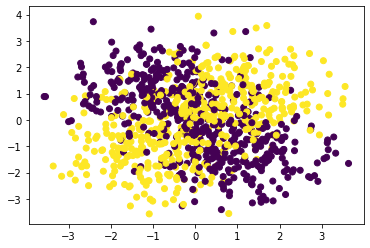

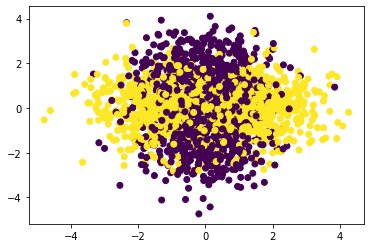

In [2]:
train_x, train_y, test_x, test_y, hybrid_sets = get_dataset(N=1000, cov_scale=1, include_hybrid=True)
plt.scatter(train_x.cpu().numpy()[:,0], train_x.cpu().numpy()[:,1], c=train_y.cpu().numpy())
plt.show()
plt.scatter(test_x.cpu().numpy()[:,0], test_x.cpu().numpy()[:,1], c=test_y.cpu().numpy())

In [4]:
def run_experiment(depth, iterations, reps=100, width=3, cov_scale=1):
    result = lambda: None
    
    xx, yy = np.meshgrid(np.arange(-2, 2, 4 / 100), np.arange(-2, 2, 4 / 100))
    true_posterior = np.array([pdf(x) for x in (np.c_[xx.ravel(), yy.ravel()])])
    
    rep_full_list = []
    imgs = []
#     train_x, train_y, test_x, test_y = get_dataset(cov_scale=cov_scale)
    train_x, train_y, test_x, test_y, hybrid_sets = get_dataset(N=1000, cov_scale=cov_scale, include_hybrid=True)
    
    depth = depth
    penultimate_vars_reps = []
    for rep in range(reps):#25
        print('rep: ' + str(rep))
        # Shffle train set labels
        train_y_tmp = torch.clone(train_y)
        # train_y[train_y_tmp==0] = 1
        # train_y[train_y_tmp==1] = 0
        # test_y_tmp = torch.clone(test_y)
        # test_y[test_y_tmp==0] = 1
        # test_y[test_y_tmp==1] = 0

        del train_y_tmp
        losses_list = []
        num_pars = []
        num_poly = []
        briers = []
        gini_train, gini_test = [], []
        
        train_loss_list = []
        test_loss_list = []
        train_acc_list = []
        test_acc_list = []
        
        penultimate_acts = []
        penultimate_nodes = []
        penultimate_err = []
        penultimate_poly = []
        penultimate_vars = []
        
        avg_stab_list = []

        L_matrices = {'0/1': [], 'true_label':[], 'est_label':[], 'est_poster':[]}
        PenUlt_L_matrices = {'0/1': [], 'true_label':[], 'est_label':[], 'est_poster':[]}

        L_matrices_test = {'0/1': [], 'true_label':[], 'est_label':[], 'est_poster':[]}
        PenUlt_L_matrices_test = {'0/1': [], 'true_label':[], 'est_label':[], 'est_poster':[]}

        gen_err_list = []
        
        for i in range(1, iterations):#20
            print('now running', i)

            ## Increasing Depth
            if depth:
                if i < 5:
                    model = get_model(n_hidden = i, hidden_size=i, penultimate=False, bn=False)
                else:
                    model = get_model(n_hidden = i, penultimate=False, bn=False)
            else:
            ## Increasing Width
                model = get_model(hidden_size = i, n_hidden=width, penultimate=False, bn=False)

            n_par = sum(p.numel() for p in model.parameters())

            losses = train_model(model, train_x, train_y)

            poly, penultimate_act = get_polytopes(model, train_x, penultimate=False)
            test_poly, penultimate_act = get_polytopes(model, test_x, penultimate=False)
            n_poly = len(np.unique(poly[0]))

            if depth:
                n_nodes = i*20 if i>5 else i*i
            else:
                n_nodes = i*3

            
            with torch.no_grad():
                pred_train, pred_test = model(train_x), model(test_x)
                
                train_y = train_y.type_as(pred_train)
                test_y  = test_y.type_as(pred_test)
                train_loss = torch.nn.BCEWithLogitsLoss()(pred_train, train_y)
    #             train_acc = (torch.argmax(pred_train,1) == torch.argmax(train_y,1)).sum().cpu().data.numpy().item() / train_y.size(0)
                train_acc = (torch.sigmoid(pred_train).round() == train_y).sum().cpu().data.numpy().item() / train_y.size(0)
                test_loss = torch.nn.BCEWithLogitsLoss()(pred_test, test_y)
    #             test_acc = (torch.argmax(pred_test,1) == torch.argmax(test_y,1)).sum().cpu().data.numpy().item() / test_y.size(0)
                test_acc = (torch.sigmoid(pred_test).round() == test_y).sum().cpu().data.numpy().item() / test_y.size(0)

            losses_list.append(losses)
            num_pars.append(n_par)
            num_poly.append(n_poly)

            train_loss_list.append(train_loss.item())
            test_loss_list.append(test_loss.item())
            train_acc_list.append(1-train_acc)
            test_acc_list.append(1-test_acc)                                                                                                                

            ### --------- Internal Representation  ----- ###
            ## -----h* on training data --------- ###
            pred_poster = torch.sigmoid(pred_train)
            pred_label = pred_poster.round()
            pred_poster = pred_poster.cpu().numpy()
            pred_label = pred_label.cpu().numpy()
            y_train = train_y.cpu().numpy()
            unique_poly = np.unique(poly[0])
            
            for key in L_matrices:
                L_mat = np.zeros((len(poly[0]), n_poly))
                for idx, poly_i in enumerate(poly[0]):
                    poly_idx = np.where(unique_poly==poly_i)
                    if key == '0/1':
                        L_mat[idx, poly_idx] = 1#pred_label[idx]
                    elif key == 'true_label':
                        L_mat[idx, poly_idx] = 2*y_train[idx]-1
                    elif key == 'est_label':
                        L_mat[idx, poly_idx] = 2*pred_label[idx]-1
                    elif key == 'est_poster':
                        L_mat[idx, poly_idx] = 2*pred_poster[idx]-1

                gen_err = abs((1-test_acc) - (1-train_acc))
                L_matrices[key].append(L_mat)
            
            gen_err_list.append(gen_err)

            binary_pattern = binary_pattern_mat(model, train_x)
            unique_pattern = np.unique(binary_pattern)
            
            for key in PenUlt_L_matrices:
                PenUlt_L_mat = np.zeros((len(binary_pattern), len(unique_pattern)))
                for idx, binary_i in enumerate(binary_pattern):
                    pattern_idx = np.where(unique_pattern==binary_i)
                    if key == '0/1':
                        PenUlt_L_mat[idx, pattern_idx] = 1 #pred_label[idx]
                    elif key == 'true_label':
                        PenUlt_L_mat[idx, pattern_idx] = 2*y_train[idx]-1
                    elif key == 'est_label':
                        PenUlt_L_mat[idx, pattern_idx] = 2*pred_label[idx]-1
                    elif key == 'est_poster':
                        PenUlt_L_mat[idx, pattern_idx] = 2*pred_poster[idx]-1
                    # PenUlt_L_mat[idx, pattern_idx] = 1
                # gen_err = abs((1-test_acc) - (1-train_acc))
                PenUlt_L_matrices[key].append(PenUlt_L_mat)
            # gen_err_list.append(gen_err)

            ### -----h* on test data --------- ###
            poly = test_poly 
            n_poly = len(np.unique(poly[0]))
            pred_poster = torch.sigmoid(pred_test)
            pred_label = pred_poster.round()
            pred_poster = pred_poster.cpu().numpy()
            pred_label = pred_label.cpu().numpy()
            y_train = test_y.cpu().numpy()
            unique_poly = np.unique(poly[0])
            ### ----------- // --------------- ###
            for key in L_matrices_test:
                L_mat = np.zeros((len(poly[0]), n_poly))
                for idx, poly_i in enumerate(poly[0]):
                    poly_idx = np.where(unique_poly==poly_i)
                    if key == '0/1':
                        L_mat[idx, poly_idx] = 1#pred_label[idx]
                    elif key == 'true_label':
                        L_mat[idx, poly_idx] = 2*y_train[idx]-1
                    elif key == 'est_label':
                        L_mat[idx, poly_idx] = 2*pred_label[idx]-1
                    elif key == 'est_poster':
                        L_mat[idx, poly_idx] = 2*pred_poster[idx]-1

                gen_err = abs((1-test_acc) - (1-train_acc))
                L_matrices_test[key].append(L_mat)
            
            gen_err_list.append(gen_err)

            binary_pattern = binary_pattern_mat(model, train_x)
            unique_pattern = np.unique(binary_pattern)
            
            for key in PenUlt_L_matrices_test:
                PenUlt_L_mat = np.zeros((len(binary_pattern), len(unique_pattern)))
                for idx, binary_i in enumerate(binary_pattern):
                    pattern_idx = np.where(unique_pattern==binary_i)
                    if key == '0/1':
                        PenUlt_L_mat[idx, pattern_idx] = 1 #pred_label[idx]
                    elif key == 'true_label':
                        PenUlt_L_mat[idx, pattern_idx] = 2*y_train[idx]-1
                    elif key == 'est_label':
                        PenUlt_L_mat[idx, pattern_idx] = 2*pred_label[idx]-1
                    elif key == 'est_poster':
                        PenUlt_L_mat[idx, pattern_idx] = 2*pred_poster[idx]-1
                    # PenUlt_L_mat[idx, pattern_idx] = 1
                # gen_err = abs((1-test_acc) - (1-train_acc))
                PenUlt_L_matrices_test[key].append(PenUlt_L_mat)


    return L_matrices, PenUlt_L_matrices, gen_err_list, num_pars, train_acc_list, test_acc_list, train_loss_list, test_loss_list, L_matrices_test, PenUlt_L_matrices_test   

In [4]:
for i in range(0, 10):
    result_d = run_experiment(depth=True, iterations=19, reps=1)
    result_w = run_experiment(depth=False, iterations=70, reps=1)
    result_d_dict = {'matrices':result_d[0], 'pen_matrices':result_d[1], 'gen_gap': result_d[2], 'train_gen_err': result_d[4], 'test_gen_err': result_d[5], 'train_loss': result_d[6], 'test_loss': result_d[7], 'n_pars': result_d[3], 'matrices_test': result_d[8], 'pen_matrices_test':result_d[9]}
    result_w_dict = {'matrices':result_w[0], 'pen_matrices': result_w[1], 'gen_gap': result_w[2], 'train_gen_err': result_w[4], 'test_gen_err': result_w[5], 'train_loss': result_w[6], 'test_loss': result_w[7], 'n_pars': result_w[3], 'matrices_test': result_w[8], 'pen_matrices_test':result_w[9]}
    np.savez_compressed('results_%s.npz'%str(i), result_w=result_w_dict, result_d=result_d_dict)


